In [43]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, random_split, Dataset
from torchvision import models, transforms, datasets, models
import torchvision.transforms as transforms
!pip install ultralytics
from ultralytics import YOLO
from PIL import Image
from sklearn.metrics import confusion_matrix
import csv
!pip install timm
import timm
import seaborn as sn
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import accuracy_score

***PREPROCESSING***

In [157]:
demo_dir = '/kaggle/input/demo-imags/demo'
num_classes = 65
image_shape = (224, 224)

In [158]:
class MakeDataset(Dataset):
    def __init__(self, root_folder, transform=None):
        self.root_folder = root_folder
        self.transform = transform
        self.classes = sorted(os.listdir(root_folder), key=lambda x: int(x))
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}
        self.images = self.make_dataset()

    def make_dataset(self):
        images = []
        for label in self.classes:
            label_folder = os.path.join(self.root_folder, label)
            for image_name in os.listdir(label_folder):
                image_path = os.path.join(label_folder, image_name)
                item = (image_path, self.class_to_idx[label])
                images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image_path, label = self.images[index]
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label

In [159]:
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize(image_shape),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [160]:
demoset = MakeDataset(demo_dir, transform=transform)

In [182]:
demo_loader = DataLoader(demoset, batch_size=1, shuffle=False)

**Model Ready**

In [162]:
#Final Delivery (Running with squeeze and excitation blocks)
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

class InceptionWithSE(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionWithSE, self).__init__()
        self.branch1 = nn.Sequential(
            nn.Conv2d(in_channels, ch1x1, kernel_size=1),
            nn.BatchNorm2d(ch1x1),
            nn.ReLU(True),
            SEBlock(ch1x1)
        )
        
        self.branch2 = nn.Sequential(
            nn.Conv2d(in_channels, ch3x3red, kernel_size=1),
            nn.BatchNorm2d(ch3x3red),
            nn.ReLU(True),
            nn.Conv2d(ch3x3red, ch3x3, kernel_size=3, padding=1),
            nn.BatchNorm2d(ch3x3),
            nn.ReLU(True),
            SEBlock(ch3x3)
        )
        
        self.branch3 = nn.Sequential(
            nn.Conv2d(in_channels, ch5x5red, kernel_size=1),
            nn.BatchNorm2d(ch5x5red),
            nn.ReLU(True),
            nn.Conv2d(ch5x5red, ch5x5, kernel_size=5, padding=2),
            nn.BatchNorm2d(ch5x5),
            nn.ReLU(True),
            SEBlock(ch5x5)
        )
        
        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            nn.Conv2d(in_channels, pool_proj, kernel_size=1),
            nn.BatchNorm2d(pool_proj),
            nn.ReLU(True),
            SEBlock(pool_proj)
        )

    def forward(self, x):
        outputs = [self.branch1(x), self.branch2(x), self.branch3(x), self.branch4(x)]
        return torch.cat(outputs, 1)

class GoogLeNetSE(nn.Module):
    def __init__(self, num_classes=65):
        super(GoogLeNetSE, self).__init__()
        self.base_model = models.googlenet(pretrained=True, transform_input=False)

        # Replace each Inception module with one that includes SE blocks
        self.base_model.inception3a = InceptionWithSE(192, 64, 96, 128, 16, 32, 32)
        self.base_model.inception3b = InceptionWithSE(256, 128, 128, 192, 32, 96, 64)
        self.base_model.inception4a = InceptionWithSE(480, 192, 96, 208, 16, 48, 64)
        self.base_model.inception4b = InceptionWithSE(512, 160, 112, 224, 24, 64, 64)
        self.base_model.inception4c = InceptionWithSE(512, 128, 128, 256, 24, 64, 64)
        self.base_model.inception4d = InceptionWithSE(512, 112, 144, 288, 32, 64, 64)
        self.base_model.inception4e = InceptionWithSE(528, 256, 160, 320, 32, 128, 128)
        self.base_model.inception5a = InceptionWithSE(832, 256, 160, 320, 32, 128, 128)
        self.base_model.inception5b = InceptionWithSE(832, 384, 192, 384, 48, 128, 128)

        # Replaceing the last fully connected layer to match the number of classes
        self.base_model.fc = nn.Linear(1024, num_classes)

    def forward(self, x):
        return self.base_model(x)

In [163]:
device1 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device2 = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device3 = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [165]:
#Original Model
googlenett = models.googlenet(pretrained=True)
googlenett.fc = nn.Linear(googlenett.fc.in_features, 65)
googlenett = googlenett.to(device1)

optimizer = torch.optim.Adam(googlenett.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [166]:
#Final Delivery (Running with Swin Transformer Base Patch 4, Window 7)
swin_transformer = timm.create_model('swin_base_patch4_window7_224', pretrained=True, num_classes=65)
swin_transformer = swin_transformer.to(device2)

optimizer = torch.optim.Adam(swin_transformer.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

In [167]:
#Final Delivery (Running with squeeze and excitation blocks)
googlenet_se = GoogLeNetSE(num_classes=65).to(device3)

optimizer = torch.optim.Adam(googlenet_se.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
criterion = nn.CrossEntropyLoss()

**Load Weights to Model Directly**

In [168]:
googlenett.load_state_dict(torch.load("/kaggle/input/googlnett-weights/googlenett_weights.pth"))
swin_transformer.load_state_dict(torch.load("/kaggle/input/swin-weights/swin_transformer_weights.pth"))
googlenet_se.load_state_dict(torch.load("/kaggle/input/googlenetse-weight/googlenet_se_weights.pth"))

<All keys matched successfully>

**Ensemble**

In [217]:
def vote(finall):
    """
    Perform a vote on each element of the given lists.
    In case of a tie, the value from the first list is chosen.
    
    Returns:
    - List containing the voted values.
    """
    result = []
    list_len = len(finall[0])

    for i in range(list_len):
        # Count occurrences of each element in the current position
        counts = {}
        for lst in finall:
            value = lst[i]
            counts[value] = counts.get(value, 0) + 1
        
        # Find the element with the maximum count
        max_count = max(counts.values())
        candidates = [key for key, count in counts.items() if count == max_count]
        
        # Choose the winner, or use the value from the first list in case of a tie
        winner = candidates[0] if len(candidates) == 1 else finall[0][i]
        result.append(finall[1])

    return result

**Demo 1**

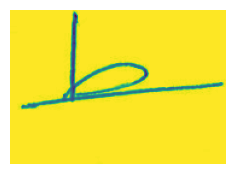

In [187]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = '/kaggle/input/demo-imags/demo/1/demo1.jpg'

# Set the desired figure size (e.g., (10, 8) inches)
figsize = (3, 2)

# Load and display the image using Matplotlib
img = mpimg.imread(image_path)
plt.figure(figsize=figsize)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels if needed
plt.show()

In [216]:
y_pred1 = []
y_pred2 = []
y_pred3 = []
y_true = []
for inputs, labels in demo_loader:
        inputs, labels = inputs.to(device1), labels.to(device1)
        output1 = googlenett(inputs) # Feed Network
        output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
        y_pred1.extend(output1) # Save Prediction
        inputs, labels = inputs.to(device2), labels.to(device2)
        
        output2 = swin_transformer(inputs) # Feed Network

        output2 = (torch.max(torch.exp(output2), 1)[1]).data.cpu().numpy()
        y_pred2.extend(output2) # Save Prediction
        inputs, labels = inputs.to(device3), labels.to(device3)

        output3 = googlenet_se(inputs) # Feed Network

        output3 = (torch.max(torch.exp(output3), 1)[1]).data.cpu().numpy()
        y_pred3.extend(output3) # Save Prediction
        print(y_pred3)

        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

ensemble_predictions = vote([y_pred1, y_pred2, y_pred3])
print(ensemble_predictions[0][0])

[11]
[11, 11]
[11, 11, 11]
[11, 11, 11, 13]
[11, 11, 11, 13, 13]
56


**Demo 2**

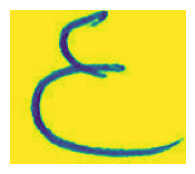

In [178]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = '/kaggle/input/demo-imags/demo/2/demo2.jpg'

# Set the desired figure size (e.g., (10, 8) inches)
figsize = (3, 2)

# Load and display the image using Matplotlib
img = mpimg.imread(image_path)
plt.figure(figsize=figsize)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels if needed
plt.show()

In [226]:
y_pred1 = []
y_pred2= []
y_pred3 = []
y_true = []
for inputs, labels in demo_loader:
        inputs, labels = inputs.to(device1), labels.to(device1)

        output1 = googlenett(inputs) # Feed Network

        output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
        y_pred1.extend(output1) # Save Prediction
        inputs, labels = inputs.to(device2), labels.to(device2)
        
        output2 = swin_transformer(inputs) # Feed Network

        output2 = (torch.max(torch.exp(output2), 1)[1]).data.cpu().numpy()
        y_pred2.extend(output2) # Save Prediction

        inputs, labels = inputs.to(device3), labels.to(device3)

        output3 = googlenet_se(inputs) # Feed Network

        output3 = (torch.max(torch.exp(output3), 1)[1]).data.cpu().numpy()
        y_pred3.extend(output3) # Save Prediction
        
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
    
ensemble_predictions = vote([y_pred1, y_pred2, y_pred3])
print(ensemble_predictions[0][1])

5


**Demo 3**

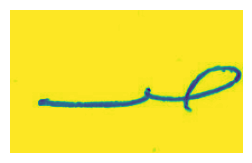

In [176]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = '/kaggle/input/demo-imags/demo/3/demo3.jpg'

# Set the desired figure size (e.g., (10, 8) inches)
figsize = (3, 2)

# Load and display the image using Matplotlib
img = mpimg.imread(image_path)
plt.figure(figsize=figsize)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels if needed
plt.show()

In [230]:
y_pred1 = []
y_pred2= []
y_pred3 = []
y_true = []
for inputs, labels in demo_loader:
    inputs = inputs.to(device1)
    labels = labels.numpy()

    output1 = googlenett(inputs)
    output1 = torch.max(output1, 1)[1].cpu().numpy()

    output2 = swin_transformer(inputs)
    output2 = torch.max(output2, 1)[1].cpu().numpy()

    output3 = googlenet_se(inputs)
    output3 = torch.max(output3, 1)[1].cpu().numpy()

    y_pred1.extend(output1)
    y_pred2.extend(output2)
    y_pred3.extend(output3)
    y_true.extend(labels)

ensemble_predictions = vote([y_pred1, y_pred2, y_pred3])
print(ensemble_predictions[0][2])

48


**Demo 4**

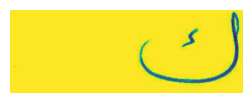

In [155]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = '/kaggle/input/demo-imags/demo/4/demo4.jpg'

# Set the desired figure size (e.g., (10, 8) inches)
figsize = (3, 2)

# Load and display the image using Matplotlib
img = mpimg.imread(image_path)
plt.figure(figsize=figsize)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels if needed
plt.show()

In [229]:
y_pred1 = []
y_pred2= []
y_pred3 = []
y_true = []
for inputs, labels in demo_loader:
        inputs, labels = inputs.to(device1), labels.to(device1)

        output1 = googlenett(inputs) # Feed Network

        output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
        y_pred1.extend(output1) # Save Prediction
        
        inputs, labels = inputs.to(device2), labels.to(device2)
        
        output2 = swin_transformer(inputs) # Feed Network

        output2 = (torch.max(torch.exp(output2), 1)[1]).data.cpu().numpy()
        y_pred2.extend(output2) # Save Prediction
        
        inputs, labels = inputs.to(device3), labels.to(device3)

        output3 = googlenet_se(inputs) # Feed Network

        output3 = (torch.max(torch.exp(output3), 1)[1]).data.cpu().numpy()
        y_pred3.extend(output3) # Save Prediction
        
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

ensemble_predictions = vote([y_pred1, y_pred2, y_pred3])
print(ensemble_predictions[0][3])

29


**Demo 5**

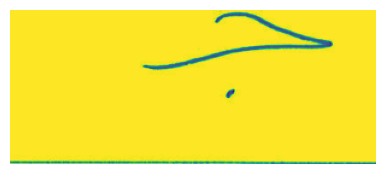

In [136]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_path = '/kaggle/input/demo-imags/demo/5/demo5.jpg'

# Set the desired figure size (e.g., (10, 8) inches)
figsize = (10, 2)

# Load and display the image using Matplotlib
img = mpimg.imread(image_path)
plt.figure(figsize=figsize)
plt.imshow(img)
plt.axis('off')  # Turn off axis labels if needed
plt.show()

In [228]:
y_pred1 = []
y_pred2= []
y_pred3 = []
y_true = []
for inputs, labels in demo_loader:
        inputs, labels = inputs.to(device1), labels.to(device1)

        output1 = googlenett(inputs) # Feed Network

        output1 = (torch.max(torch.exp(output1), 1)[1]).data.cpu().numpy()
        y_pred1.extend(output1) # Save Prediction
        
        inputs, labels = inputs.to(device2), labels.to(device2)
        
        output2 = swin_transformer(inputs) # Feed Network

        output2 = (torch.max(torch.exp(output2), 1)[1]).data.cpu().numpy()
        y_pred2.extend(output2) # Save Prediction
        
        inputs, labels = inputs.to(device3), labels.to(device3)

        output3 = googlenet_se(inputs) # Feed Network

        output3 = (torch.max(torch.exp(output3), 1)[1]).data.cpu().numpy()
        y_pred3.extend(output3) # Save Prediction
        
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

ensemble_predictions = vote([y_pred1, y_pred2, y_pred3])
print(ensemble_predictions[0][4])

22
